# Importing dataset from google drive

In [10]:
#importing the brown.csv from google drive
from google.colab import drive
drive.mount('/content/drive')
import pandas as pd
path = "/content/drive/MyDrive/brown.csv"
df = pd.read_csv(path)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [11]:
df.head()

,filename,para_id,sent_id,raw_text,tokenized_text,tokenized_pos,label
0,cd05,0,0,"Furthermore/rb ,/, as/cs an/at encouragement/n...","Furthermore , as an encouragement to revisioni...","rb , cs at nn in nn nn , pps rb bez jj to vb c...",religion
1,cd05,0,1,The/at Unitarian/jj clergy/nns were/bed an/at ...,The Unitarian clergy were an exclusive club of...,at jj nns bed at jj nn in vbn nns -- cs at nn ...,religion
2,cd05,0,2,"Ezra/np Stiles/np Gannett/np ,/, an/at honorab...","Ezra Stiles Gannett , an honorable representat...","np np np , at jj nn in at nn , vbd ppl rb in a...",religion
3,cd05,0,3,"Even/rb so/rb ,/, Gannett/np judiciously/rb ar...","Even so , Gannett judiciously argued , the Ass...","rb rb , np rb vbd , at nn-tl md rb vb cs np ``...",religion
4,cd05,0,4,We/ppss today/nr are/ber not/* entitled/vbn to...,We today are not entitled to excoriate honest ...,ppss nr ber * vbn to vb jj nns wps vbd np to b...,religion


# Data Preperation

In [12]:
#importing libraries
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
from collections import Counter

# storing the "tokenized_text" and "tokenized_pos" from the dataset

TEXT_COL = "tokenized_text"
TAG_COL = "tokenized_pos"


corpus_sent=[]   # this will store the cleaned sentences (word, tag) pairs
bad_rows = 0        # counter for "bad rows" where words and tags don't match

# go through every row in the dataset
for _, row in df.iterrows():

    words = str(row[TEXT_COL]).split() # split the sentence into words
    tags  = str(row[TAG_COL]).split() # split the POS tags

    # this will keep the row only if the number of words matches the number of tags
    # and non-empty sentences
    if len(words) == len(tags) and len(words) > 0:
        corpus_sent.append(list(zip(words, tags))) # to pair each word with its tag and store it
    else:
        bad_rows += 1    # otherwise count it as a "bad row"

# print dataset stats after cleaning
print("Usable sentences:", len(corpus_sent))
print("Bad rows:", bad_rows)

Usable sentences: 57339
Bad rows: 1


In [13]:
#removing redundant sentences
unique = {}
for sent in corpus_sent:
    unique[tuple(sent)] = sent

corpus_sent= list(unique.values())
print("After dedup:", len(corpus_sent))

After dedup: 56463


# Re-usability and data splitting

In [14]:

RANDOM_STATE = 42  # fixed seed so results are reproducible every time
random.seed(RANDOM_STATE)
np.random.seed(RANDOM_STATE)

random.shuffle(corpus_sent) # shuffling the data for fair distrubution for training and testing set for teh model to not memorize

split = int(0.8 * len(corpus_sent)) # splitting data to 80% training and 20% testing
train_sent= corpus_sent[:split]
test_sent = corpus_sent[split:]

# printing the number of training and testing sentences
print("Train:", len(train_sent))
print("Test :", len(test_sent))

Train: 45170
Test : 11293


# Training models

In [9]:
# importing Natural Language Tool Kit (nltk) to train teh models
import nltk
from nltk.tag import DefaultTagger, UnigramTagger, BigramTagger, TrigramTagger, HiddenMarkovModelTagger
from nltk.tag.perceptron import PerceptronTagger

#assigning default tag noun(nn) to words
DEFAULT_TAG = "nn"

# backoff chain of N-gram mdoels
t0 = DefaultTagger(DEFAULT_TAG)
t1 = UnigramTagger(train_sent, backoff=t0)
t2 = BigramTagger(train_sent, backoff=t1)
t3 = TrigramTagger(train_sent, backoff=t2)

#training HMM
print("Training HMM...")
hmm_tagger = HiddenMarkovModelTagger.train(train_sent)

#training Perceptron from scratch
print("Training Perceptron...")
perceptron_tagger = PerceptronTagger(load=False)
perceptron_tagger.train(train_sent)

# creating a dictionary to organize all the trained POS taggers
# to loop over all models for evaluation, like checking accuracy on a test set
models = {
    "Default": t0,
    "Unigram": t1,
    "Bigram": t2,
    "Trigram": t3,
    "HMM": hmm_tagger,
    "Perceptron": perceptron_tagger
}

Training HMM...
Training Perceptron...


# Testing Models' performance - Token Sentence, IV and OOV accuracy

In [16]:
from collections import defaultdict # importing defaultdict (a dictionary with default values)

# to extract only the words from test sentences
# example: [(dog,NN),(runs,VB)] -> [dog, runs]
test_words_list = [[w for (w, _) in sent] for sent in test_sent]

# to extract the correct (gold) POS tags from test sentences
# example: [(dog,NN),(runs,VB)] -> [NN, VB]
test_gold_list  = [[t for (_, t) in sent] for sent in test_sent]


# to build vocabulary of words seen during training this is used later to check IV (seen words) vs OOV (unseen words)
train_vocab = {w for sent in train_sent for (w, _) in sent}


def evaluate_model_fast(tagger):

    # to count for token level accuracy
    total_tokens = 0
    correct_tokens = 0

    # to count for sentence level accuracy
    sent_correct = 0
    sent_total = len(test_sent)

    # to count for in-vocabulary and out-of-vocabulary words
    iv_total = iv_correct = 0
    oov_total = oov_correct = 0

    # to go through each test sentence
    for words, gold in zip(test_words_list, test_gold_list):

        # to get predicted tags from the model
        pred = [t for (_, t) in tagger.tag(words)]

        # to check token accuracy and IV/OOV in the same loop
        all_correct = True

        for w, g, p in zip(words, gold, pred):

            total_tokens += 1

            # give the correct prediction
            if g == p:
                correct_tokens += 1
            else:
                all_correct = False

            # to check if word was seen during training
            if w in train_vocab:
                iv_total += 1
                iv_correct += (g == p)
            else:
                oov_total += 1
                oov_correct += (g == p)

        # if every tag in the sentence is correct
        if all_correct:
            sent_correct += 1

    # calculating final metrics
    token_acc = correct_tokens / total_tokens if total_tokens else float("nan")
    sent_acc  = sent_correct / sent_total if sent_total else float("nan")
    iv_acc    = iv_correct / iv_total if iv_total else float("nan")
    oov_acc   = oov_correct / oov_total if oov_total else float("nan")

    return token_acc, sent_acc, iv_acc, oov_acc


# stores evaluation results of each model
results = []

for name, tagger in models.items():

    # running evaluation
    acc, sacc, iv_acc, oov_acc = evaluate_model_fast(tagger)

    # saving results
    results.append({
        "Model": name,
        "TokenAcc": acc,
        "SentenceAcc": sacc,
        "IV_Acc": iv_acc,
        "OOV_Acc": oov_acc
    })

# converting results into a dataframe and sorting by best accuracy
results_df = pd.DataFrame(results).sort_values("TokenAcc", ascending=False)

print(results_df)

        Model  TokenAcc  SentenceAcc    IV_Acc   OOV_Acc
5  Perceptron  0.962759     0.560878  0.967464  0.780203
4         HMM  0.934304     0.377668  0.952291  0.236295
3     Trigram  0.922898     0.320464  0.941273  0.209830
2      Bigram  0.922880     0.317011  0.941255  0.209830
1     Unigram  0.902002     0.221907  0.919839  0.209830
0     Default  0.131487     0.000089  0.129468  0.209830


# Visualizing model comparison





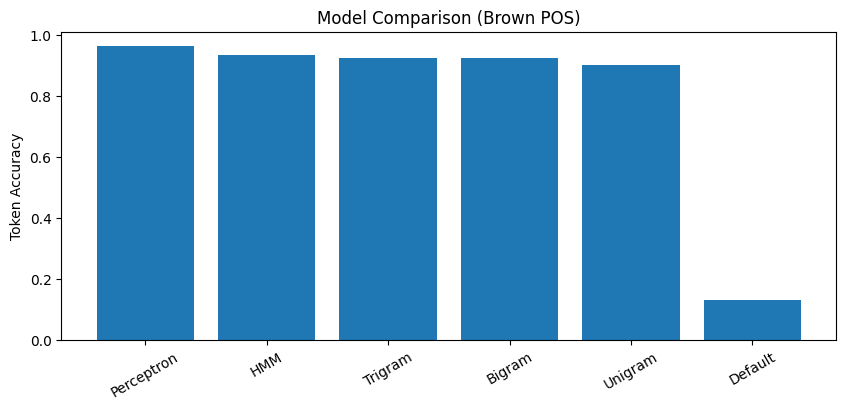

In [17]:
plt.figure(figsize=(10,4))
plt.bar(results_df["Model"], results_df["TokenAcc"])
plt.xticks(rotation=30)
plt.ylabel("Token Accuracy")
plt.title("Model Comparison (Brown POS)")
plt.show()

# Evalution Metrics for each POS tag: Precision, Recall, F1 score and Support (how many times each tag actually appears in your test sentences).

In [18]:
from sklearn.metrics import classification_report, confusion_matrix

# geting the name of the best performing model (highest accuracy)
best_model_name = results_df.iloc[0]["Model"]

# geting the actual tagger object from the models dictionary
best_tagger = models[best_model_name]

# lists to store all true tags and predicted tags
gold_all = []
pred_all = []

# looping through every sentence in the test data
for sent in test_sent:

    # extracting only the words from the sentence
    words = [w for w, _ in sent]

    # extracting the correct (gold standard) POS tags
    gold  = [t for _, t in sent]

    # getting predicted tags from the best model
    pred  = [t for _, t in best_tagger.tag(words)]

    # adding results to the full lists for evaluation
    gold_all.extend(gold)
    pred_all.extend(pred)

# printing which model performed the best
print("\nBest model:", best_model_name)

# show precision, recall and f1-score for each POS tag
print(classification_report(gold_all, pred_all))


Best model: Perceptron


/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_

              precision    recall  f1-score   support

           '       1.00      1.00      1.00        66
          ''       1.00      1.00      1.00      1684
           (       0.95      1.00      0.98       424
        (-hl       0.75      0.14      0.23        22
           )       0.97      0.99      0.98       410
        )-hl       0.79      0.73      0.76        26
           *       1.00      1.00      1.00       929
        *-hl       0.00      0.00      0.00         1
           ,       1.00      1.00      1.00     11584
        ,-hl       0.00      0.00      0.00        36
          --       0.99      1.00      1.00       683
       ---hl       0.00      0.00      0.00         6
           .       0.99      1.00      1.00     12092
        .-hl       0.00      0.00      0.00        81
        .-nc       0.00      0.00      0.00         2
          16       0.00      0.00      0.00         0
        16''       0.00      0.00      0.00         2
     16-inch       0.00    

/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


# Error analysis:

In [19]:

def show_errors(n=5):
    count = 0  # counter for how many error sentences have been shown
    for sent in test_sent:
        words = [w for w, _ in sent]   # extracting words only
        gold  = [t for _, t in sent]   # extracting correct (gold) tags
        pred  = [t for _, t in best_tagger.tag(words)]  # geting predicted tags

        # only showing sentences where at least one word is tagged incorrectly
        if any(g != p for g, p in zip(gold, pred)):
            print("\nSentence:", " ".join(words))

            # showing which words were tagged wrongly
            for i in range(len(words)):
                if gold[i] != pred[i]:
                    print(f"  {words[i]}: GOLD={gold[i]} PRED={pred[i]}")

            count += 1
            if count >= n:  # stopping after showing n sentences
                break

show_errors()


Sentence: Into the texture of this tapestry of history and human drama Henrietta , as every artist delights to do , wove strands of her own intuitive insights into human nature and -- especially in the remarkable story of the attraction and conflict between two so disparate and fervent characters as this pair -- into the relations of men and women : `` In their relations , she was the giver and he the receiver , nay the demander .
  delights: GOLD=vbz PRED=nns
  wove: GOLD=vbd PRED=vb
  nay: GOLD=rb PRED=vb

Sentence: Said Joyce .
  Said: GOLD=vbn PRED=vbd

Sentence: Obviously , if this club is going to move from second to first in the American League , it will have to show improvement someplace .
  someplace: GOLD=rb PRED=nn

Sentence: Only the vain and incurably sentimental among us will lose sleep simply because foreign peoples are not as impressed by our strength as they ought to be .
  vain: GOLD=jj PRED=nn
  incurably: GOLD=ql PRED=rb

Sentence: The `` Essex Journal '' says that

## Top 15 Confused Tag Pairs

In [20]:
from collections import Counter

confusions = Counter()

for g, p in zip(gold_all, pred_all):
    if g != p:
        confusions[(g, p)] += 1

print("Top 15 Confused Tag Pairs:")
for (g, p), count in confusions.most_common(15):
    print(f"{g} → {p}: {count}")


Top 15 Confused Tag Pairs:
nn → jj: 458
jj → nn: 391
vbn → vbd: 279
np-tl → np: 232
vb → nn: 222
rp → in: 208
vbd → vbn: 195
nn-hl → nn: 169
vbz → nns: 158
cs → in: 137
ql → rb: 135
nn-tl → np: 132
nn → np: 129
rb → ql: 123
nn → vbg: 115


Most Frequently Mis-Tagged Words

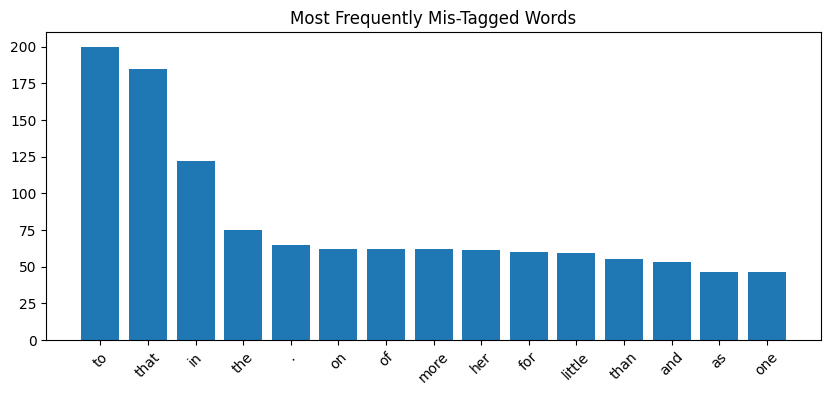

In [21]:
word_errors = Counter()

for sent in test_sent:
    words = [w for w, _ in sent]
    gold  = [t for _, t in sent]
    pred  = [t for _, t in best_tagger.tag(words)]

    for w, g, p in zip(words, gold, pred):
        if g != p:
            word_errors[w] += 1

top_words = word_errors.most_common(15)
words, counts = zip(*top_words)

plt.figure(figsize=(10,4))
plt.bar(words, counts)
plt.xticks(rotation=45)
plt.title("Most Frequently Mis-Tagged Words")
plt.show()


# Vizualisation

## Confusion matrix:

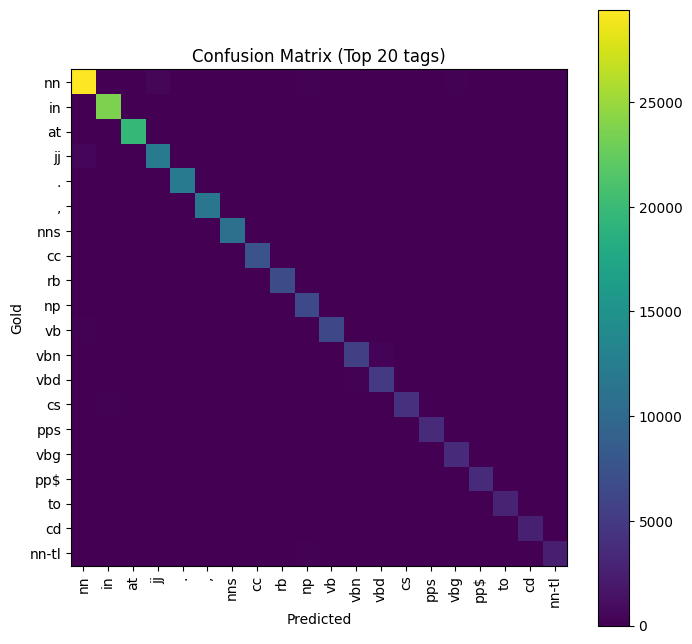

In [22]:
tag_counts = Counter(gold_all)
top_tags = [t for t, _ in tag_counts.most_common(20)]

cm = confusion_matrix(gold_all, pred_all, labels=top_tags)

plt.figure(figsize=(8,8))
plt.imshow(cm)
plt.xticks(range(len(top_tags)), top_tags, rotation=90)
plt.yticks(range(len(top_tags)), top_tags)
plt.title("Confusion Matrix (Top 20 tags)")
plt.xlabel("Predicted")
plt.ylabel("Gold")
plt.colorbar()
plt.show()


## IV vs OOV Accuracy

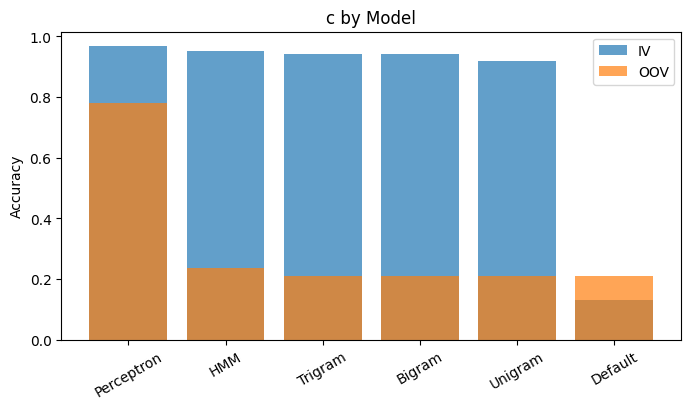

In [23]:
plt.figure(figsize=(8,4))
plt.bar(results_df["Model"], results_df["IV_Acc"], alpha=0.7, label="IV")
plt.bar(results_df["Model"], results_df["OOV_Acc"], alpha=0.7, label="OOV")
plt.xticks(rotation=30)
plt.ylabel("Accuracy")
plt.title("c by Model")
plt.legend()
plt.show()


## Top 20 POS Tags Distribution

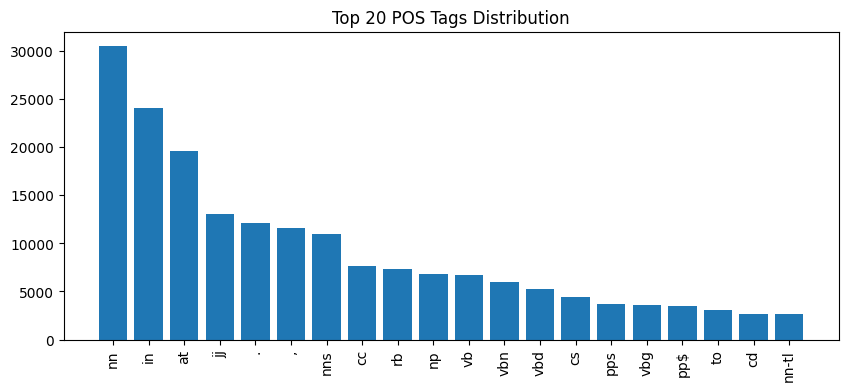

In [24]:
tag_counts = Counter(gold_all)
tags, counts = zip(*tag_counts.most_common(20))

plt.figure(figsize=(10,4))
plt.bar(tags, counts)
plt.xticks(rotation=90)
plt.title("Top 20 POS Tags Distribution")
plt.show()


## Sentence Length vs Accuracy

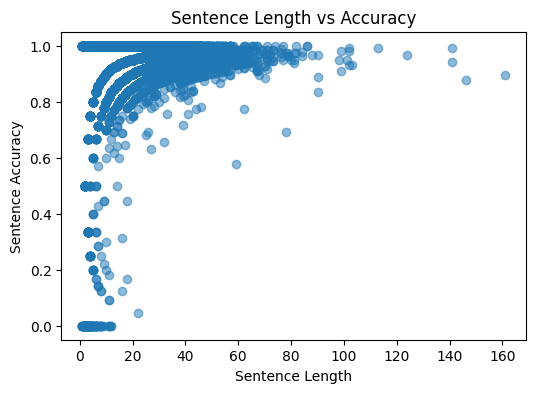

In [25]:
length_acc = []

for sent in test_sent:
    words = [w for w, _ in sent]
    gold  = [t for _, t in sent]
    pred  = [t for _, t in best_tagger.tag(words)]

    correct = sum(g == p for g, p in zip(gold, pred))
    acc = correct / len(sent)
    length_acc.append((len(sent), acc))

lengths, accs = zip(*length_acc)

plt.figure(figsize=(6,4))
plt.scatter(lengths, accs, alpha=0.5)
plt.xlabel("Sentence Length")
plt.ylabel("Sentence Accuracy")
plt.title("Sentence Length vs Accuracy")
plt.show()


## Sentence-Level Accuracy Comparison

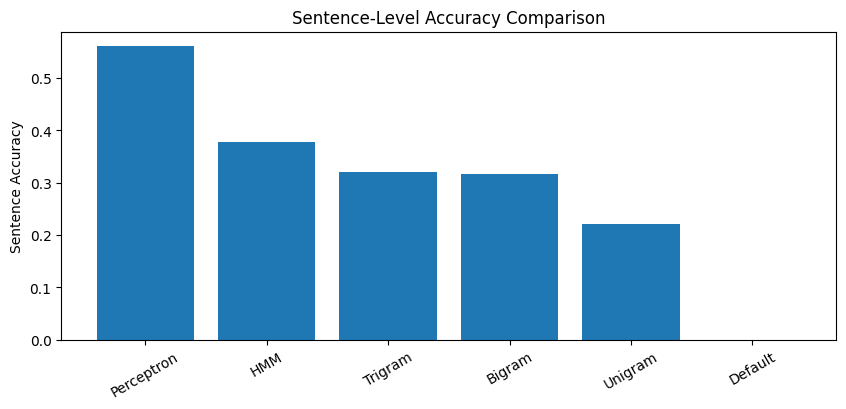

In [26]:
plt.figure(figsize=(10,4))
plt.bar(results_df["Model"], results_df["SentenceAcc"])
plt.xticks(rotation=30)
plt.ylabel("Sentence Accuracy")
plt.title("Sentence-Level Accuracy Comparison")
plt.show()
